# Planet: Understanding the Amazon from Space

In [1]:
from fastai.vision import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Fine-tuning a pre-trained model using progressive resizing

In [2]:
path = Path('../data')
path

PosixPath('/home/ncondo/.fastai/data/planet')

In [3]:
labels_df = pd.read_csv(data_path/'train_v2.csv')
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Set the type of transforms we want to perform while training

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Now create a ```DataBunch``` for training the model

In [5]:
np.random.seed(14)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [1]:
bs=64

In [6]:
data = (src.transform(tfms, size=64)
       .databunch(bs=bs).normalize(imagenet_stats))

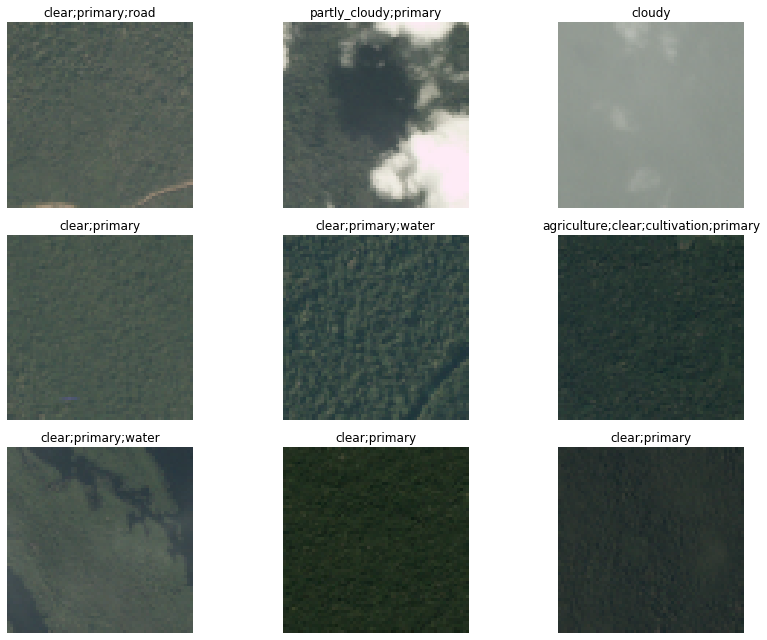

In [7]:
data.show_batch(rows=3, figsize=(12,9))

Load the pre-trained model and create a learner with accuracy and f2 score as metrics. I've trained 5 different models: ```models.resnet50```, ```models.resnet101```, ```models.resnet152```, ```models.densenet121```, ```models.densenet169```.

In [8]:
arch = models.resnet50
model_name = 'resnet50'

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [10]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Use fastai's learning rate finder to get a good learning rate 

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


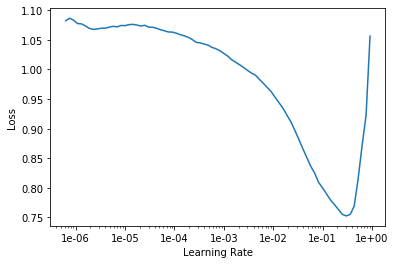

In [12]:
learn.recorder.plot()

We can fit the head of our network

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.154489,0.137753,0.938081,0.879497,01:01
1,0.121770,0.109720,0.940370,0.902719,01:01
2,0.114453,0.101706,0.947956,0.909753,01:05
3,0.103818,0.097163,0.949301,0.910459,01:05
4,0.098505,0.095836,0.949453,0.912886,01:08


In [15]:
learn.save(model_name+'-stage-1-64')

And then fine-tune the whole network

In [16]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


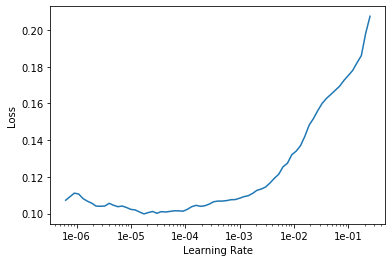

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.105041,0.099746,0.949962,0.910965,01:12
1,0.106484,0.096662,0.947905,0.914374,01:11
2,0.099098,0.093096,0.949497,0.915179,01:13
3,0.093526,0.089691,0.953712,0.920816,01:12
4,0.088130,0.089266,0.955288,0.920124,01:15


In [19]:
learn.save(model_name+'-stage-2-64')

Now we can fine-tune the model using 128x128 images

In [20]:
data = (src.transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [21]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


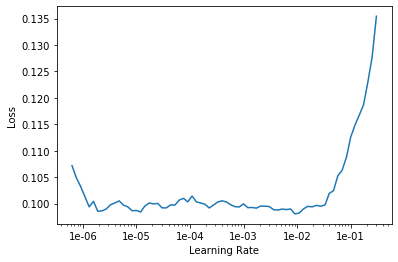

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr=1e-2/2

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091289,0.087629,0.954954,0.923395,01:55
1,0.087473,0.088304,0.961022,0.921821,01:55
2,0.089059,0.085991,0.959387,0.925583,01:55
3,0.085823,0.083822,0.957875,0.925748,01:55
4,0.084409,0.083623,0.958144,0.927076,01:55


In [25]:
learn.save(model_name+'-stage-1-128')

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089337,0.086303,0.958856,0.923240,02:30
1,0.087720,0.085138,0.958675,0.924913,02:30
2,0.085500,0.084201,0.958856,0.927019,02:30
3,0.079449,0.082621,0.957817,0.926255,02:30
4,0.075078,0.082460,0.959808,0.927502,02:30


In [28]:
learn.save(model_name+'-stage-2-128')

In [29]:
data = (src.transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [30]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


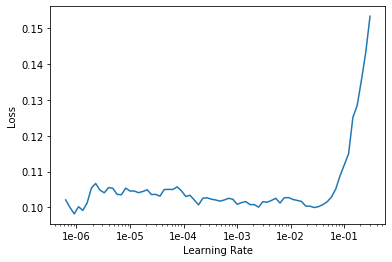

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr=1e-2/2

In [33]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088918,0.088760,0.958043,0.919270,07:04
1,0.087219,0.087030,0.959169,0.920879,07:03
2,0.086783,0.085995,0.960680,0.923856,07:03
3,0.091805,0.084540,0.959888,0.925568,07:03
4,0.088833,0.085524,0.961465,0.923299,07:03
5,0.087945,0.105932,0.960600,0.925437,07:03
6,0.082319,0.171247,0.958820,0.923251,07:03
7,0.082062,0.099469,0.959510,0.924729,07:03
8,0.078288,0.085771,0.960193,0.925237,07:02
9,0.076813,0.118382,0.959328,0.926530,07:02


In [34]:
learn.save(model_name+'-stage-1-256')

In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084657,0.092786,0.959059,0.927113,09:04
1,0.087825,0.089248,0.955891,0.922508,09:03
2,0.086726,0.087268,0.960150,0.923502,09:10
3,0.084025,0.175093,0.957614,0.922767,09:12
4,0.083159,0.131352,0.958420,0.925054,09:05
5,0.081186,0.103508,0.958043,0.923988,09:05
6,0.080605,0.105457,0.962293,0.924669,09:04
7,0.075650,0.098144,0.960034,0.927835,09:03
8,0.072563,0.109912,0.960724,0.927902,09:03
9,0.073095,0.109643,0.961552,0.927906,09:03


In [38]:
learn.save(model_name+'-stage-2-256')

In [39]:
learn.export(model_name)